# Classify Flowers Using Measurements

This example is from: https://machinelearningmastery.com/tutorial-to-implement-k-nearest-neighbors-in-python-from-scratch/

The test problem we will be using in this tutorial is iris classification.

Based on the sepal length, sepal width, petal length and petal width of 150 observations of iris flowers, we need to implement a classification model to predict the species, which is one of setosa, versicolor or virginica.

It is a standard dataset where the species is known for all instances. As such we can split the data into training and test datasets and use the results to evaluate our algorithm implementation. Good classification accuracy on this problem is above 90% correct, typically 96% or better.

Here is a iris flower image:
<img src="iris_petal_sepal.png" />

# How to implement k-Nearest Neighbors in Python

This tutorial is broken down into the following steps:

1. Handle Data: Open the dataset from CSV and split into test/train datasets.
2. Similarity: Calculate the distance between two data instances.
3. Neighbors: Locate k most similar data instances.
4. Response: Generate a response from a set of data instances.
5. Accuracy: Summarize the accuracy of predictions.
6. Main: Tie it all together.


## 1. Handle Data

The first thing we need to do is load our data file. The data is in CSV format without a header line or any quotes. We can open the file with the open function and read the data lines using the reader function in the csv module.

In [1]:
import pandas as pd

url = 'https://raw.githubusercontent.com/ruiwu1990/CSCI_4120/master/KNN/iris.data'
df = pd.read_csv(url, header=None)
print(df.head())

     0    1    2    3            4
0  5.1  3.5  1.4  0.2  Iris-setosa
1  4.9  3.0  1.4  0.2  Iris-setosa
2  4.7  3.2  1.3  0.2  Iris-setosa
3  4.6  3.1  1.5  0.2  Iris-setosa
4  5.0  3.6  1.4  0.2  Iris-setosa


Next we need to split the data into a training dataset that kNN can use to make predictions and a test dataset that we can use to evaluate the accuracy of the model.

We first need to convert the flower measures that were loaded as strings into numbers that we can work with. Next we need to split the data set randomly into train and datasets. A ratio of 67/33 for train/test is a standard ratio used.

Pulling it all together, we can define a function called loadDataset that loads a CSV with the provided filename and splits it randomly into train and test datasets using the provided split ratio.

In [2]:
import pandas as pd
import random


def loadDataset(filename, split):
	trainingSet=[]
	testSet=[]
	df = pd.read_csv(url, header=None)
	array = df.to_numpy()
	random.shuffle(array)
	training_len = int(len(array)*split)
	trainingSet = array[:training_len]
	testSet = array[training_len:]
	return trainingSet, testSet

We can test this function out with our iris dataset, as follows:

In [3]:
trainingSet=[]
testSet=[]
url = 'https://raw.githubusercontent.com/ruiwu1990/CSCI_4120/master/KNN/iris.data'
trainingSet, testSet = loadDataset(url, 0.66)

# repr() Return a string containing a printable representation
print('Train: ' + repr(len(trainingSet)))
print('Test: ' + repr(len(testSet)))

Train: 99
Test: 51


## 2. Similarity

In order to make predictions we need to calculate the similarity between any two given data instances. This is needed so that we can locate the k most similar data instances in the training dataset for a given member of the test dataset and in turn make a prediction.

Given that all four flower measurements are numeric and have the same units, we can directly use the Euclidean distance measure. This is defined as the square root of the sum of the squared differences between the two arrays of numbers (read that again a few times and let it sink in).

Additionally, we want to control which fields to include in the distance calculation. Specifically, we only want to include the first 4 attributes. One approach is to limit the euclidean distance to a fixed length, ignoring the final dimension.

Putting all of this together we can define the euclideanDistance function as follows:

In [19]:
import math
def euclideanDistance(instance1, instance2, length):
	distance = 0
	for x in range(length):
		distance += pow((instance1[x] - instance2[x]), 2)
	return math.sqrt(distance)

We can test this function with some sample data, as follows:

In [20]:
data1 = [2, 2, 2, 2, 'a']
data2 = [4, 4, 4, 4, 'b']
distance = euclideanDistance(data1, data2, 4)
print('Distance: ' + repr(distance))

Distance: 4.0


## 3. Neighbors

Now that we have a similarity measure, we can use it collect the k most similar instances for a given unseen instance.

This is a straight forward process of calculating the distance for all instances and selecting a subset with the smallest distance values.

Below is the getNeighbors function that returns k most similar neighbors from the training set for a given test instance (using the already defined euclideanDistance function)

In [28]:
import operator 
def getNeighbors(trainingSet, testInstance, k):
	distances = []
	length = len(testInstance)-1
	for x in range(len(trainingSet)):
		dist = euclideanDistance(testInstance, trainingSet[x], length)
		distances.append((trainingSet[x], dist))
    # key=operator.itemgetter(1) => order distances list based on second column (1)
	distances.sort(key=operator.itemgetter(1))
	neighbors = []
	for x in range(k):
		neighbors.append(distances[x][0])
	return neighbors

We can test out this function as follows:

In [29]:
trainSet = [[2, 2, 2, 'a'], [4, 4, 4, 'b']]
testInstance = [5, 5, 5, 'b']
k = 1
neighbors = getNeighbors(trainSet, testInstance, k)
print(neighbors)

[[4, 4, 4, 'b']]


## 4. Response

Once we have located the most similar neighbors for a test instance, the next task is to devise a predicted response based on those neighbors.

We can do this by allowing each neighbor to vote for their class attribute, and take the majority vote as the prediction.

Below provides a function for getting the majority voted response from a number of neighbors. It assumes the class is the last attribute for each neighbor.

In [23]:
import operator
def getResponse(neighbors):
    # classVotes is a dict, similar to JSON
    # e.g., {'a': 1, 'b': 2}
	classVotes = {}
	for x in range(len(neighbors)):
        # based on the last element
		response = neighbors[x][-1]
		if response in classVotes:
			classVotes[response] += 1
		else:
			classVotes[response] = 1
    # reverse=True means the most voted item will be our response
    # itemgetter(1): get the first item, i.e. item with most votes
	sortedVotes = sorted(classVotes.items(), key=operator.itemgetter(1), reverse=True)
	return sortedVotes[0][0]

We can test out this function with some test neighbors, as follows:

In [24]:
neighbors = [[1,1,1,1,'a'], [2,2,2,2,'a'], [3,3,3,3,'b']]
response = getResponse(neighbors)
print(response)

a


This approach returns one response in the case of a draw, but you could handle such cases in a specific way, such as returning no response or selecting an unbiased random response.

## 5. Accuracy

We have all of the pieces of the kNN algorithm in place. An important remaining concern is how to evaluate the accuracy of predictions.

An easy way to evaluate the accuracy of the model is to calculate a ratio of the total correct predictions out of all predictions made, called the classification accuracy.

Below is the getAccuracy function that sums the total correct predictions and returns the accuracy as a percentage of correct classifications.

In [25]:
def getAccuracy(testSet, predictions):
	correct = 0
	for x in range(len(testSet)):
		if testSet[x][-1] is predictions[x]:
			correct += 1
	return (correct/float(len(testSet))) * 100.0

We can test this function with a test dataset and predictions, as follows:

In [4]:
testSet = [[1,1,1,1,'a'], [2,2,2,2,'a'], [3,3,3,3,'b']]
predictions = ['a', 'a', 'a']
accuracy = getAccuracy(testSet, predictions)
print(accuracy)

NameError: name 'getAccuracy' is not defined

## 6. Main

We now have all the elements of the algorithm and we can tie them together with a main function.

Below is the example of implementing the kNN algorithm from scratch in Python.

Group Activity: You need to finish the TODO section.

In [10]:
import pandas as pd
import random
import math
import operator

def loadDataset(filename, split):
    trainingSet = []
    testSet = []
    df = pd.read_csv(filename, header=None)
    array = df.to_numpy()
    random.shuffle(array)
    training_len = int(len(array) * split)
    trainingSet = array[:training_len]
    testSet = array[training_len:]
    return trainingSet, testSet

def euclideanDistance(instance1, instance2, length):
    distance = 0
    for x in range(length):
        distance += pow((instance1[x] - instance2[x]), 2)
    return math.sqrt(distance)

def getNeighbors(trainingSet, testInstance, k):
    distances = []
    length = len(testInstance) - 1
    for x in range(len(trainingSet)):
        dist = euclideanDistance(testInstance, trainingSet[x], length)
        distances.append((trainingSet[x], dist))
    distances.sort(key=operator.itemgetter(1))
    neighbors = []
    for x in range(k):
        neighbors.append(distances[x][0])
    return neighbors

def getResponse(neighbors):
    classVotes = {}
    for x in range(len(neighbors)):
        response = neighbors[x][-1]
        if response in classVotes:
            classVotes[response] += 1
        else:
            classVotes[response] = 1
    sortedVotes = sorted(classVotes.items(), key=operator.itemgetter(1), reverse=True)
    return sortedVotes[0][0]

def getAccuracy(testSet, predictions):
    correct = 0
    for x in range(len(testSet)):
        if testSet[x][-1] == predictions[x]:
            correct += 1
    return (correct / float(len(testSet))) * 100.0

def main():
 
    trainingSet = []
    testSet = []
    split = 0.67
    url = 'https://raw.githubusercontent.com/ruiwu1990/CSCI_4120/master/KNN/iris.data'
    trainingSet, testSet = loadDataset(url, split)
    print('Train set: ' + repr(len(trainingSet)))
    print('Test set: ' + repr(len(testSet)))

  
    predictions = []
    k = 3

    # Loop through testSet
    for x in range(len(testSet)):
       
        neighbors = getNeighbors(trainingSet, testSet[x], k)

      
        result = getResponse(neighbors)

        
        predictions.append(result)
        print('> predicted=' + repr(result) + ', actual=' + repr(testSet[x][-1]))

    accuracy = getAccuracy(testSet, predictions)
    print('Accuracy: ' + repr(accuracy) + '%')

main()


Train set: 100
Test set: 50
> predicted='Iris-setosa', actual='Iris-setosa'
> predicted='Iris-setosa', actual='Iris-setosa'
> predicted='Iris-versicolor', actual='Iris-versicolor'
> predicted='Iris-versicolor', actual='Iris-versicolor'
> predicted='Iris-versicolor', actual='Iris-versicolor'
> predicted='Iris-setosa', actual='Iris-setosa'
> predicted='Iris-setosa', actual='Iris-setosa'
> predicted='Iris-setosa', actual='Iris-setosa'
> predicted='Iris-setosa', actual='Iris-setosa'
> predicted='Iris-setosa', actual='Iris-setosa'
> predicted='Iris-setosa', actual='Iris-setosa'
> predicted='Iris-versicolor', actual='Iris-versicolor'
> predicted='Iris-versicolor', actual='Iris-versicolor'
> predicted='Iris-versicolor', actual='Iris-virginica'
> predicted='Iris-setosa', actual='Iris-setosa'
> predicted='Iris-versicolor', actual='Iris-virginica'
> predicted='Iris-setosa', actual='Iris-setosa'
> predicted='Iris-versicolor', actual='Iris-versicolor'
> predicted='Iris-setosa', actual='Iris-setosa

k=1, Average Accuracy: 94.80%
k=2, Average Accuracy: 95.20%
k=3, Average Accuracy: 94.00%
k=4, Average Accuracy: 96.80%
k=5, Average Accuracy: 95.20%
k=6, Average Accuracy: 97.60%
k=7, Average Accuracy: 97.20%
k=8, Average Accuracy: 98.80%
k=9, Average Accuracy: 98.00%
k=10, Average Accuracy: 96.40%
k=11, Average Accuracy: 98.00%
k=12, Average Accuracy: 97.20%
k=13, Average Accuracy: 97.20%
k=14, Average Accuracy: 95.20%
k=15, Average Accuracy: 97.20%
k=16, Average Accuracy: 94.00%
k=17, Average Accuracy: 96.00%
k=18, Average Accuracy: 96.00%
k=19, Average Accuracy: 96.00%
k=20, Average Accuracy: 94.00%


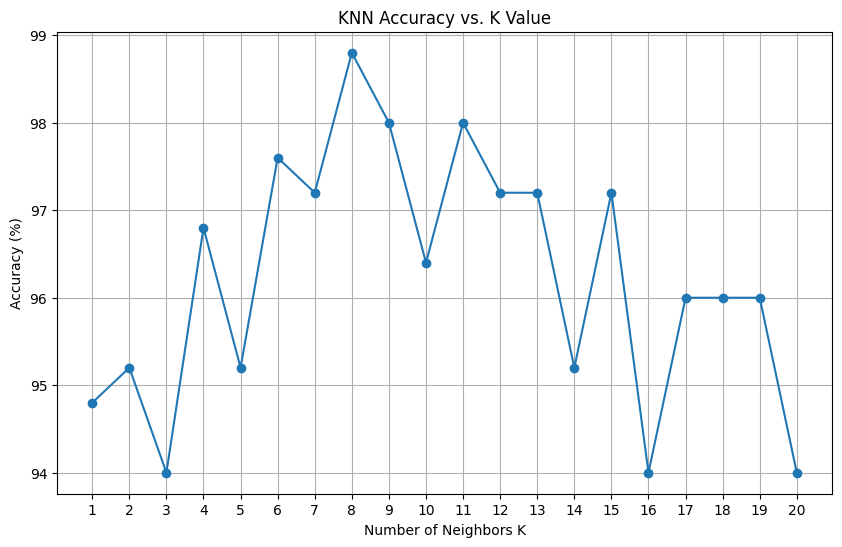

In [13]:
import pandas as pd
import random
import math
import operator
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

def loadDataset(filename):
    df = pd.read_csv(filename, header=None)
    return df

def main():
    # Load data
    url = 'https://raw.githubusercontent.com/ruiwu1990/CSCI_4120/master/KNN/iris.data'
    data = loadDataset(url)
    
    # Split the dataset into features and target
    X = data.iloc[:, :-1].values  # Features (all columns except last)
    y = data.iloc[:, -1].values    # Target (last column)
    

    accuracies = []

 
    for k in range(1, 21):
        
        total_accuracy = 0
        for _ in range(5):  
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=random.randint(0, 100))

       
            knn = KNeighborsClassifier(n_neighbors=k)

            # Fit the model
            knn.fit(X_train, y_train)

            # Calculate accuracy
            accuracy = knn.score(X_test, y_test)
            total_accuracy += accuracy

        
        average_accuracy = total_accuracy / 5
        accuracies.append(average_accuracy)
        print(f'k={k}, Average Accuracy: {average_accuracy * 100:.2f}%')

 
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, 21), [a * 100 for a in accuracies], marker='o')
    plt.title('KNN Accuracy vs. K Value')
    plt.xlabel('Number of Neighbors K')
    plt.ylabel('Accuracy (%)')
    plt.xticks(range(1, 21))
    plt.grid()
    plt.savefig('knn_accuracy_chart.png') 
    plt.show()  

if __name__ == "__main__":
    main()
